In [3]:
import pandas as pd
import numpy as np
import sys
sys.path.append("..")  
from openai import OpenAI
import re
from typing import Optional
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
load_dotenv()
import csv

In [4]:
DEEPSEEK_API_KEY = os.getenv("DEEPSEEK_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [8]:
ACTIVITY = 'activity'
DEVICE = 'device'
START_TIME = 'start_time'
END_TIME = 'end_time'
TIME = 'time'
VALUE = 'value'
NAME = 'name'

DATASET ='A'
DATA_DIR = 'LLM_segment_A'

# api_key = DEEPSEEK_API_KEY  
# client = OpenAI(api_key=api_key, base_url="https://api.deepseek.com")
# model_name = "deepseek-chat"
# MODEL="deepseek"

api_key = OPENAI_API_KEY
client = OpenAI(api_key=api_key)
model_name="gpt-4o-mini-2024-07-18"
MODEL="gpt-4o-mini"
temperature=0

In [4]:
import sys
sys.path.append("..")  
from data_load.load_data import load_ordoneza_dataset_nochange
from pathlib import Path

dataset_b = load_ordoneza_dataset_nochange(Path("../dataset/UCI_ADL_Binary"), part=DATASET)
print(dataset_b['activities'].head())
print(dataset_b['devices'].head())
print(dataset_b.keys())
print(dataset_b['activity_list'])

           start_time            end_time             activity
0 2011-11-28 02:27:59 2011-11-28 10:18:11             sleeping
2 2011-11-28 10:25:44 2011-11-28 10:33:00            showering
3 2011-11-28 10:34:23 2011-11-28 10:43:00  preparing breakfast
4 2011-11-28 10:49:48 2011-11-28 10:51:13        personal care
5 2011-11-28 10:51:41 2011-11-28 13:05:07    relaxing on couch
           start_time            end_time location      type     place  \
0 2011-11-28 02:27:59 2011-11-28 10:18:11      Bed  Pressure   Bedroom   
1 2011-11-28 10:21:24 2011-11-28 10:21:31  Cabinet  Magnetic  Bathroom   
2 2011-11-28 10:21:44 2011-11-28 10:23:31    Basin       PIR  Bathroom   
3 2011-11-28 10:23:02 2011-11-28 10:23:36   Toilet     Flush  Bathroom   
4 2011-11-28 10:25:44 2011-11-28 10:32:06   Shower       PIR  Bathroom   

                      device  
0       Bedroom_Bed_Pressure  
1  Bathroom_Cabinet_Magnetic  
2         Bathroom_Basin_PIR  
3      Bathroom_Toilet_Flush  
4        Bathroom_Show

In [5]:
from data_process.preprocess import convert_events_to_states

state_df = convert_events_to_states(dataset_b['devices'], DATASET)
print(state_df)
# state_df.head(40)

                                             state          start_time  \
0            st(Bedroom-BedOccupied, 02:27, 10:18) 2011-11-28 02:27:59   
1       st(Bathroom-CabinetDoorOpen, 10:21, 10:21) 2011-11-28 10:21:24   
2     st(Bathroom-NearBathroomBasin, 10:21, 10:23) 2011-11-28 10:21:44   
3           st(Bathroom-ToiletFlush, 10:23, 10:23) 2011-11-28 10:23:02   
4    st(Bathroom-NearBathroomShower, 10:25, 10:32) 2011-11-28 10:25:44   
..                                             ...                 ...   
404       st(Kitchen-FridgeDoorOpen, 15:13, 15:13) 2011-12-11 15:13:52   
405         st(Bathroom-ToiletFlush, 15:29, 15:30) 2011-12-11 15:29:03   
406   st(Bathroom-NearBathroomBasin, 15:41, 15:43) 2011-12-11 15:41:34   
407          st(Living-SeatOccupied, 15:43, 00:22) 2011-12-11 15:43:51   
408          st(Bedroom-BedOccupied, 00:31, 07:22) 2011-12-12 00:31:35   

               end_time location      type     place  \
0   2011-11-28 10:18:11      Bed  Pressure   Bedroom   

In [7]:
def identify_activity_edges_from_raw_data(df):
    """
    根据传感器原始数据识别活动边缘（开始时间和结束时间）。
    假设输入数据的列包含 'start_time', 'end_time', 'state', 'location', 'place' 等。
    """
    # 确保时间列是 datetime 类型
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['end_time'] = pd.to_datetime(df['end_time'])

    system_prompt = """
    Analyze the provided raw sensor data and identify distinct indoor human activities.
    For each activity, determine the start and end times based on the sensor events.
    Ensure each activity segment has a complete semantic meaning and accurately reflects the corresponding time range.  

    Please note that activities include, but are not limited to:
    sleeping,showering,preparing breakfast,personal care,relaxing on couch,leaving home,preparing lunch,preparing dinner,snacking
        
    Return only the result in the following table format without header, without any additional explanations or summaries:
    Start time(YYYY-MM-DD HH:MM:SS),End time(YYYY-MM-DD HH:MM:SS),Activity
    
    """
    
    data_str = df.to_string(index=False)

    try:
        response = client.chat.completions.create(
            model=model_name, 
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": f"Raw sensor data:\n{data_str}"}
            ],
            max_tokens=1000,
            temperature=0.0
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        return f"Error identifying activity edges: {str(e)}"

def run_pipeline(df, window_size=50, activity_output_path=f"{DATA_DIR}/activity_edges.txt"):

    num_rows = len(df)
    
    with open(activity_output_path, "w", encoding="utf-8") as activity_file:
        for i in range(0, num_rows, window_size):
            window = df.iloc[i:i + window_size]
            
            if not window.empty:
                activity_edges = identify_activity_edges_from_raw_data(window)
                
                activity_file.write(f"{activity_edges}\n\n")
                print(f"Window {i // window_size + 1}:\n{activity_edges}\n")
    
    print(f"Activity edges saved to: {activity_output_path}")


run_pipeline(dataset_b['devices'], window_size=15)  

C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 1:
2011-11-28 02:27:59,2011-11-28 10:18:11,Sleeping  
2011-11-28 10:21:24,2011-11-28 10:21:31,Personal Care  
2011-11-28 10:21:44,2011-11-28 10:25:44,Showering  
2011-11-28 10:25:44,2011-11-28 10:32:06,Showering  
2011-11-28 10:34:23,2011-11-28 10:34:41,Preparing Breakfast  
2011-11-28 10:34:44,2011-11-28 10:37:17,Preparing Breakfast  
2011-11-28 10:38:00,2011-11-28 10:42:41,Preparing Breakfast  
2011-11-28 10:41:43,2011-11-28 10:42:55,Preparing Breakfast  
2011-11-28 10:49:48,2011-11-28 10:51:13,Personal Care  
2011-11-28 10:51:41,2011-11-28 13:05:07,Relaxing on Couch  
2011-11-28 13:06:04,2011-11-28 13:06:06,Personal Care



C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 2:
2011-11-28 13:06:07,2011-11-28 13:06:31,personal care  
2011-11-28 13:09:31,2011-11-28 13:09:35,leaving home  
2011-11-28 13:28:59,2011-11-28 13:29:09,leaving home  
2011-11-28 13:33:32,2011-11-28 13:38:23,preparing lunch  
2011-11-28 13:38:40,2011-11-28 14:21:40,relaxing on couch  
2011-11-28 14:26:38,2011-11-28 14:27:07,personal care  
2011-11-28 14:27:11,2011-11-28 14:28:46,preparing lunch  
2011-11-28 14:28:48,2011-11-28 14:28:55,preparing lunch  
2011-11-28 14:31:06,2011-11-28 14:41:54,preparing dinner  
2011-11-28 14:31:44,2011-11-28 14:31:56,preparing lunch  
2011-11-28 14:35:22,2011-11-28 14:35:27,preparing lunch  
2011-11-28 15:04:59,2011-11-28 15:06:29,personal care  
2011-11-28 15:07:01,2011-11-28 16:09:57,relaxing on couch  
2011-11-28 16:10:05,2011-11-28 16:10:05,personal care  
2011-11-28 16:10:38,2011-11-28 20:19:27,relaxing on couch



C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 3:
2011-11-28 20:21:15,2011-11-29 02:06:51,relaxing on couch  
2011-11-29 02:16:05,2011-11-29 11:31:04,sleeping  
2011-11-29 11:37:16,2011-11-29 11:37:27,personal care  
2011-11-29 11:37:38,2011-11-29 11:48:29,personal care  
2011-11-29 11:49:57,2011-11-29 11:51:13,showering  
2011-11-29 12:08:28,2011-11-29 12:09:21,preparing breakfast  
2011-11-29 12:09:09,2011-11-29 12:13:02,preparing breakfast  
2011-11-29 12:09:24,2011-11-29 12:09:37,preparing breakfast  
2011-11-29 12:09:42,2011-11-29 12:10:37,preparing breakfast  
2011-11-29 12:19:24,2011-11-29 12:21:11,personal care  
2011-11-29 12:21:56,2011-11-29 12:21:58,personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 4:
2011-11-29 12:22:38,2011-11-29 13:25:15,relaxing on couch  
2011-11-29 13:25:29,2011-11-29 13:25:32,preparing lunch  
2011-11-29 13:25:38,2011-11-29 15:12:26,relaxing on couch  
2011-11-29 15:13:28,2011-11-29 15:13:57,personal care  
2011-11-29 15:13:32,2011-11-29 15:13:34,personal care  
2011-11-29 15:14:33,2011-11-29 15:15:09,preparing lunch  
2011-11-29 15:15:14,2011-11-29 15:36:26,preparing dinner  
2011-11-29 15:15:17,2011-11-29 15:22:57,preparing lunch  
2011-11-29 15:52:04,2011-11-29 16:17:58,relaxing on couch



C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 5:
2011-11-29 16:34:17,2011-11-29 17:08:07,relaxing on couch  
2011-11-29 17:08:58,2011-11-29 17:09:29,personal care  
2011-11-29 17:09:09,2011-11-29 18:57:22,relaxing on couch  
2011-11-29 19:02:15,2011-11-29 19:02:21,leaving home  
2011-11-29 20:23:32,2011-11-29 20:23:38,leaving home  
2011-11-29 20:28:08,2011-11-30 01:19:47,relaxing on couch  
2011-11-30 01:22:33,2011-11-30 10:07:31,sleeping  
2011-11-30 10:14:07,2011-11-30 10:14:34,personal care  
2011-11-30 10:14:45,2011-11-30 10:18:33,showering  
2011-11-30 10:23:02,2011-11-30 10:23:17,preparing breakfast  
2011-11-30 10:23:21,2011-11-30 10:23:36,preparing breakfast  
2011-11-30 10:23:46,2011-11-30 10:28:38,preparing breakfast



C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 6:
2011-11-30 10:39:30,2011-11-30 10:41:13,showering  
2011-11-30 10:41:38,2011-11-30 13:05:01,relaxing on couch  
2011-11-30 13:05:27,2011-11-30 13:05:31,snacking  
2011-11-30 13:05:38,2011-11-30 14:09:34,relaxing on couch  
2011-11-30 14:11:16,2011-11-30 14:11:48,personal care  
2011-11-30 14:13:45,2011-11-30 14:34:09,relaxing on couch  
2011-11-30 14:39:42,2011-11-30 14:55:24,preparing lunch  
2011-11-30 15:11:48,2011-11-30 16:39:11,relaxing on couch  
2011-11-30 16:40:00,2011-11-30 16:40:24,personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 7:
2011-11-30 16:40:04,2011-11-30 16:40:09,Bathing  
2011-11-30 16:41:05,2011-11-30 16:41:09,Preparing Lunch  
2011-11-30 16:41:15,2011-11-30 18:00:38,Relaxing on Couch  
2011-11-30 18:01:44,2011-11-30 18:01:47,Bathing  
2011-11-30 18:01:46,2011-11-30 18:02:11,Personal Care  
2011-11-30 18:01:54,2011-11-30 18:43:20,Relaxing on Couch  
2011-11-30 18:57:08,2011-11-30 18:57:34,Personal Care  
2011-11-30 18:57:39,2011-11-30 19:37:10,Relaxing on Couch  
2011-11-30 19:37:36,2011-11-30 19:38:01,Personal Care  
2011-11-30 19:37:40,2011-11-30 19:37:46,Bathing  
2011-11-30 19:46:44,2011-11-30 19:46:49,Leaving Home  
2011-11-30 20:05:07,2011-11-30 20:05:12,Leaving Home  
2011-11-30 20:08:39,2011-11-30 20:08:44,Relaxing on Couch  
2011-11-30 20:09:07,2011-11-30 20:13:18,Preparing Dinner  
2011-11-30 20:13:39,2011-11-30 20:13:48,Bathing



C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 8:
2011-11-30 20:14:03,2011-12-01 01:34:27,relaxing on couch  
2011-12-01 01:37:52,2011-12-01 10:50:45,sleeping  
2011-12-01 10:55:03,2011-12-01 10:55:32,personal care  
2011-12-01 10:55:08,2011-12-01 10:55:13,personal care  
2011-12-01 10:55:16,2011-12-01 10:55:25,personal care  
2011-12-01 10:58:37,2011-12-01 11:12:22,showering  
2011-12-01 11:17:05,2011-12-01 11:19:49,preparing breakfast  
2011-12-01 11:30:06,2011-12-01 14:29:02,relaxing on couch  
2011-12-01 14:08:19,2011-12-01 14:08:22,personal care  
2011-12-01 14:29:37,2011-12-01 14:52:02,preparing lunch  
2011-12-01 14:29:48,2011-12-01 14:36:38,preparing lunch



C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 9:
2011-12-01 15:09:00,2011-12-01 16:26:17,relaxing on couch  
2011-12-01 16:26:35,2011-12-01 16:27:04,personal care  
2011-12-01 16:26:36,2011-12-01 17:27:13,showering  
2011-12-01 17:29:29,2011-12-01 17:29:58,leaving home  
2011-12-01 18:49:46,2011-12-01 18:49:51,leaving home  
2011-12-01 18:54:52,2011-12-01 18:54:56,preparing breakfast  
2011-12-01 18:55:03,2011-12-01 19:10:34,relaxing on couch  
2011-12-01 19:28:51,2011-12-01 19:29:17,personal care  
2011-12-01 19:29:13,2011-12-01 23:52:52,relaxing on couch  
2011-12-01 23:53:00,2011-12-01 23:53:28,personal care  
2011-12-01 23:54:32,2011-12-02 01:18:32,sleeping  
2011-12-02 01:18:44,2011-12-02 01:18:57,personal care  
2011-12-02 01:19:09,2011-12-02 02:08:17,relaxing on couch  
2011-12-02 02:09:33,2011-12-02 02:13:56,personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 10:
2011-12-02 02:15:55,2011-12-02 12:15:19,Sleeping  
2011-12-02 12:20:40,2011-12-02 12:21:09,Personal care  
2011-12-02 12:21:19,2011-12-02 12:25:40,Showering  
2011-12-02 12:29:08,2011-12-02 12:31:50,Preparing breakfast  
2011-12-02 12:29:25,2011-12-02 12:31:10,Preparing breakfast  
2011-12-02 12:37:47,2011-12-02 14:46:29,Relaxing on couch  
2011-12-02 14:46:59,2011-12-02 14:47:08,Snacking  
2011-12-02 14:47:18,2011-12-02 15:05:06,Preparing lunch  
2011-12-02 14:47:22,2011-12-02 14:50:19,Preparing lunch



C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 11:
2011-12-02 15:24:05,2011-12-02 15:55:12,relaxing on couch  
2011-12-02 15:56:02,2011-12-02 15:57:55,personal care  
2011-12-02 15:57:56,2011-12-02 16:36:05,relaxing on couch  
2011-12-02 16:47:27,2011-12-02 16:47:55,personal care  
2011-12-02 16:47:39,2011-12-02 19:39:08,relaxing on couch  
2011-12-02 19:40:44,2011-12-02 19:40:50,snacking  
2011-12-02 19:41:14,2011-12-02 21:26:09,relaxing on couch  
2011-12-02 21:44:37,2011-12-02 21:45:03,personal care  
2011-12-02 21:46:31,2011-12-03 01:41:08,sleeping  
2011-12-03 01:47:02,2011-12-03 11:56:20,sleeping  
2011-12-03 11:59:15,2011-12-03 11:59:45,personal care  
2011-12-03 11:59:33,2011-12-03 11:59:36,personal care  
2011-12-03 11:59:42,2011-12-03 12:01:34,personal care  
2011-12-03 12:03:36,2011-12-03 12:06:26,showering  
2011-12-03 12:08:53,2011-12-03 12:08:55,personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 12:
2011-12-03 12:10:35,2011-12-03 12:13:51,preparing breakfast  
2011-12-03 12:21:30,2011-12-03 13:28:36,relaxing on couch  
2011-12-03 13:29:22,2011-12-03 13:29:32,personal care  
2011-12-03 13:29:48,2011-12-03 14:01:20,relaxing on couch  
2011-12-03 14:11:10,2011-12-03 14:14:43,personal care  
2011-12-03 14:18:11,2011-12-03 14:18:23,leaving home  
2011-12-03 17:48:33,2011-12-03 17:48:37,leaving home  
2011-12-03 17:50:14,2011-12-03 20:37:41,relaxing on couch  
2011-12-03 20:37:49,2011-12-03 20:38:07,leaving home  
2011-12-03 20:38:15,2011-12-03 23:53:24,relaxing on couch  
2011-12-03 23:54:51,2011-12-03 23:55:21,personal care  
2011-12-03 23:55:18,2011-12-04 03:16:13,sleeping



C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 13:
2011-12-04 03:19:17,2011-12-04 12:37:49,Sleeping  
2011-12-04 12:45:44,2011-12-04 12:46:15,Personal Care  
2011-12-04 12:46:20,2011-12-04 12:47:28,Personal Care  
2011-12-04 12:50:56,2011-12-04 12:54:55,Showering  
2011-12-04 12:56:08,2011-12-04 12:58:48,Preparing Lunch  
2011-12-04 12:56:47,2011-12-04 12:58:37,Preparing Lunch  
2011-12-04 13:00:53,2011-12-04 13:58:10,Relaxing on Couch  
2011-12-04 14:03:42,2011-12-04 14:04:13,Personal Care  
2011-12-04 14:11:50,2011-12-04 14:11:54,Leaving Home  
2011-12-04 16:30:57,2011-12-04 16:31:01,Leaving Home  
2011-12-04 16:34:00,2011-12-04 17:25:39,Relaxing on Couch  
2011-12-04 17:27:03,2011-12-04 17:27:08,Preparing Lunch



C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 14:
2011-12-04 17:27:16,2011-12-04 17:43:56,relaxing on couch  
2011-12-04 17:45:15,2011-12-04 17:45:19,personal care  
2011-12-04 18:08:28,2011-12-04 18:57:52,relaxing on couch  
2011-12-04 18:59:06,2011-12-04 18:59:33,personal care  
2011-12-04 18:59:09,2011-12-04 18:59:12,personal care  
2011-12-04 18:59:53,2011-12-04 18:59:59,snacking  
2011-12-04 19:00:04,2011-12-04 22:20:59,relaxing on couch  
2011-12-04 22:21:42,2011-12-04 22:22:10,personal care  
2011-12-04 22:21:45,2011-12-04 22:21:57,personal care  
2011-12-04 22:22:19,2011-12-05 01:28:09,sleeping  
2011-12-05 01:31:34,2011-12-05 01:31:39,personal care  
2011-12-05 01:35:10,2011-12-05 11:48:55,sleeping  
2011-12-05 11:53:01,2011-12-05 11:53:31,personal care  
2011-12-05 11:57:47,2011-12-05 11:57:55,personal care  
2011-12-05 12:01:23,2011-12-05 12:08:56,showering



C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 15:
2011-12-05 12:10:06,2011-12-05 12:14:19,relaxing on couch  
2011-12-05 12:14:49,2011-12-05 12:14:55,preparing breakfast  
2011-12-05 12:14:58,2011-12-05 12:15:29,preparing breakfast  
2011-12-05 12:15:45,2011-12-05 12:17:41,preparing breakfast  
2011-12-05 12:15:55,2011-12-05 12:17:58,preparing breakfast  
2011-12-05 12:26:37,2011-12-05 14:26:46,relaxing on couch  
2011-12-05 14:28:36,2011-12-05 14:28:42,personal care  
2011-12-05 14:38:07,2011-12-05 14:38:32,leaving home  
2011-12-05 14:55:00,2011-12-05 14:55:06,leaving home  
2011-12-05 14:57:51,2011-12-05 15:00:54,preparing lunch  
2011-12-05 15:00:10,2011-12-05 15:00:25,preparing lunch  
2011-12-05 15:00:55,2011-12-05 15:21:30,preparing lunch  
2011-12-05 15:00:58,2011-12-05 15:13:55,preparing lunch  
2011-12-05 15:11:41,2011-12-05 15:11:45,preparing lunch



C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 16:
2011-12-05 15:42:25,2011-12-05 15:44:05,Bathing  
2011-12-05 15:44:16,2011-12-05 15:45:09,Using Toilet  
2011-12-05 15:44:56,2011-12-05 16:02:10,Relaxing on Couch  
2011-12-05 16:36:32,2011-12-05 16:37:00,Using Toilet  
2011-12-05 16:37:15,2011-12-05 17:14:32,Relaxing on Couch  
2011-12-05 17:17:07,2011-12-05 17:17:13,Leaving Home  
2011-12-05 18:57:11,2011-12-05 18:57:16,Returning Home  
2011-12-05 19:01:42,2011-12-05 19:24:02,Relaxing on Couch  
2011-12-05 19:24:11,2011-12-05 19:24:16,Using Fridge  
2011-12-05 19:24:22,2011-12-05 20:07:19,Relaxing on Couch  
2011-12-05 20:07:32,2011-12-05 20:07:47,Bathing



C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 17:
2011-12-05 20:20:20,2011-12-05 21:06:25,relaxing on couch  
2011-12-05 21:06:35,2011-12-05 21:07:08,personal care  
2011-12-05 21:07:14,2011-12-06 00:38:24,sleeping  
2011-12-06 00:39:56,2011-12-06 00:40:23,personal care  
2011-12-06 00:42:37,2011-12-06 10:07:20,sleeping  
2011-12-06 11:08:53,2011-12-06 11:09:26,personal care  
2011-12-06 11:10:06,2011-12-06 11:10:09,personal care  
2011-12-06 11:12:19,2011-12-06 11:25:57,showering  
2011-12-06 11:30:19,2011-12-06 11:33:26,preparing breakfast



C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 18:
2011-12-06 11:30:22,2011-12-06 11:30:46,preparing breakfast  
2011-12-06 11:30:52,2011-12-06 11:31:23,preparing breakfast  
2011-12-06 11:31:34,2011-12-06 11:32:49,preparing breakfast  
2011-12-06 11:39:34,2011-12-06 14:37:50,relaxing on couch  
2011-12-06 14:40:53,2011-12-06 14:41:14,preparing lunch  
2011-12-06 14:41:16,2011-12-06 15:00:58,preparing lunch  
2011-12-06 14:41:22,2011-12-06 14:51:11,preparing lunch  
2011-12-06 15:17:49,2011-12-06 15:18:18,relaxing on couch  
2011-12-06 15:18:35,2011-12-06 15:20:32,personal care  
2011-12-06 15:21:46,2011-12-06 17:11:04,relaxing on couch  
2011-12-06 17:18:22,2011-12-06 17:18:49,personal care  
2011-12-06 17:19:04,2011-12-06 17:19:14,personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 19:
2011-12-06 17:19:34,2011-12-06 18:06:26,relaxing on couch  
2011-12-06 18:07:03,2011-12-06 18:07:15,personal care  
2011-12-06 18:07:36,2011-12-06 19:22:33,relaxing on couch  
2011-12-06 19:22:50,2011-12-06 19:22:55,snacking  
2011-12-06 19:25:56,2011-12-06 19:26:20,personal care  
2011-12-06 19:40:28,2011-12-07 00:07:38,relaxing on couch  
2011-12-07 00:07:47,2011-12-07 00:07:57,personal care  
2011-12-07 00:08:10,2011-12-07 00:54:50,relaxing on couch  
2011-12-07 00:57:29,2011-12-07 00:57:53,personal care  
2011-12-07 00:59:56,2011-12-07 10:45:40,sleeping  
2011-12-07 10:49:26,2011-12-07 10:49:54,personal care  
2011-12-07 10:50:38,2011-12-07 10:50:43,personal care  
2011-12-07 10:50:45,2011-12-07 11:04:14,personal care  
2011-12-07 11:04:19,2011-12-07 11:04:25,personal care  
2011-12-07 11:05:51,2011-12-07 11:11:32,showering



C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 20:
2011-12-07 11:12:17,2011-12-07 11:17:14,preparing breakfast  
2011-12-07 11:22:58,2011-12-07 13:56:10,relaxing on couch  
2011-12-07 14:03:34,2011-12-07 14:03:42,personal care  
2011-12-07 14:04:32,2011-12-07 14:15:04,preparing lunch  
2011-12-07 14:41:59,2011-12-07 15:28:03,relaxing on couch  
2011-12-07 15:31:23,2011-12-07 15:32:18,personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 21:
2011-12-07 15:32:15,2011-12-07 16:11:28,relaxing on couch  
2011-12-07 16:15:26,2011-12-07 16:21:09,personal care  
2011-12-07 16:25:45,2011-12-07 16:25:52,leaving home  
2011-12-07 18:12:30,2011-12-07 18:12:36,leaving home  
2011-12-07 18:14:56,2011-12-07 18:14:59,personal care  
2011-12-07 18:15:03,2011-12-07 18:15:29,personal care  
2011-12-07 18:15:51,2011-12-07 19:21:46,relaxing on couch  
2011-12-07 19:23:32,2011-12-07 19:23:39,leaving home  
2011-12-07 19:23:55,2011-12-07 19:24:00,snacking  
2011-12-07 19:24:02,2011-12-07 19:24:05,snacking  
2011-12-07 19:28:41,2011-12-07 19:28:46,snacking  
2011-12-07 20:37:50,2011-12-07 20:37:51,snacking  
2011-12-07 20:38:13,2011-12-07 20:38:18,snacking  
2011-12-07 20:39:16,2011-12-07 20:39:44,personal care  
2011-12-07 20:40:29,2011-12-07 20:42:35,relaxing on couch



C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 22:
2011-12-07 20:52:23,2011-12-07 23:19:30,relaxing on couch  
2011-12-07 23:19:40,2011-12-07 23:19:56,personal care  
2011-12-07 23:20:16,2011-12-08 01:32:32,relaxing on couch  
2011-12-08 01:39:41,2011-12-08 11:14:29,sleeping  
2011-12-08 11:17:37,2011-12-08 11:17:48,personal care  
2011-12-08 11:17:58,2011-12-08 11:18:30,personal care  
2011-12-08 11:19:22,2011-12-08 11:24:17,showering  
2011-12-08 11:25:12,2011-12-08 11:28:25,preparing breakfast



C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 23:
2011-12-08 11:36:09,2011-12-08 13:41:19,relaxing on couch  
2011-12-08 14:04:49,2011-12-08 14:05:01,personal care  
2011-12-08 14:10:03,2011-12-08 14:10:07,leaving home  
2011-12-08 16:21:37,2011-12-08 16:21:41,leaving home  
2011-12-08 16:24:27,2011-12-08 22:13:23,relaxing on couch  
2011-12-08 22:13:35,2011-12-08 22:13:49,personal care  
2011-12-08 22:14:14,2011-12-08 23:12:37,relaxing on couch  
2011-12-08 23:14:09,2011-12-08 23:14:27,personal care  
2011-12-08 23:14:35,2011-12-09 01:03:07,relaxing on couch  
2011-12-09 01:04:24,2011-12-09 01:05:43,personal care  
2011-12-09 01:16:42,2011-12-09 10:49:07,sleeping  
2011-12-09 10:51:56,2011-12-09 10:52:27,personal care  
2011-12-09 10:52:30,2011-12-09 10:52:36,personal care  
2011-12-09 10:52:40,2011-12-09 10:52:50,personal care  
2011-12-09 10:54:58,2011-12-09 10:58:21,showering



C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 24:
2011-12-09 11:00:13,2011-12-09 11:03:09,preparing breakfast  
2011-12-09 11:09:35,2011-12-09 12:32:57,relaxing on couch  
2011-12-09 12:33:21,2011-12-09 12:42:15,personal care  
2011-12-09 12:44:16,2011-12-09 12:44:20,leaving home  
2011-12-09 16:33:52,2011-12-09 16:33:56,leaving home  
2011-12-09 16:45:53,2011-12-09 16:59:52,relaxing on couch  
2011-12-09 17:04:57,2011-12-09 17:05:23,personal care  
2011-12-09 17:06:38,2011-12-09 17:59:19,relaxing on couch  
2011-12-09 17:59:25,2011-12-09 17:59:27,personal care  
2011-12-09 18:02:18,2011-12-09 18:19:35,relaxing on couch  
2011-12-09 18:32:02,2011-12-09 18:32:07,leaving home



C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 25:
2011-12-09 18:48:30,2011-12-09 18:48:36,leaving home  
2011-12-09 18:50:33,2011-12-09 18:50:45,snacking  
2011-12-09 19:19:54,2011-12-09 21:04:31,relaxing on couch  
2011-12-09 21:04:37,2011-12-09 21:04:50,personal care  
2011-12-09 21:04:59,2011-12-10 00:16:21,relaxing on couch  
2011-12-10 00:16:31,2011-12-10 00:16:49,personal care  
2011-12-10 00:17:05,2011-12-10 00:46:13,relaxing on couch  
2011-12-10 00:50:47,2011-12-10 09:26:17,sleeping  
2011-12-10 09:35:48,2011-12-10 09:36:18,personal care  
2011-12-10 09:37:16,2011-12-10 09:37:21,personal care  
2011-12-10 09:37:26,2011-12-10 09:45:53,personal care  
2011-12-10 09:46:00,2011-12-10 09:46:05,personal care  
2011-12-10 09:46:23,2011-12-10 09:46:27,personal care  
2011-12-10 09:47:44,2011-12-10 09:52:42,showering  
2011-12-10 09:55:18,2011-12-10 09:55:26,snacking



C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 26:
2011-12-10 09:55:50,2011-12-10 09:59:03,preparing breakfast  
2011-12-10 09:56:27,2011-12-10 09:56:29,preparing breakfast  
2011-12-10 09:56:33,2011-12-10 09:56:50,preparing breakfast  
2011-12-10 09:56:58,2011-12-10 09:58:18,preparing breakfast  
2011-12-10 09:58:21,2011-12-10 09:58:24,preparing breakfast  
2011-12-10 10:03:20,2011-12-10 12:34:09,relaxing on couch  
2011-12-10 12:52:54,2011-12-10 12:53:39,personal care  
2011-12-10 13:04:03,2011-12-10 13:04:08,leaving home  
2011-12-10 17:06:58,2011-12-10 17:07:03,leaving home  
2011-12-10 17:11:23,2011-12-10 20:16:51,relaxing on couch  
2011-12-10 20:21:54,2011-12-10 20:23:16,personal care  
2011-12-10 20:25:40,2011-12-10 20:25:46,leaving home  
2011-12-11 00:56:01,2011-12-11 00:56:05,leaving home  
2011-12-11 01:01:41,2011-12-11 02:26:08,relaxing on couch  
2011-12-11 02:27:21,2011-12-11 02:28:44,personal care



C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 27:
2011-12-11 02:31:15,2011-12-11 11:57:34,Sleeping  
2011-12-11 12:01:27,2011-12-11 12:01:59,Personal Care  
2011-12-11 12:02:25,2011-12-11 12:02:39,Personal Care  
2011-12-11 12:02:56,2011-12-11 12:18:42,Showering  
2011-12-11 12:21:57,2011-12-11 12:25:12,Preparing Breakfast  
2011-12-11 12:32:49,2011-12-11 14:26:18,Relaxing on Couch  
2011-12-11 14:34:12,2011-12-11 14:34:59,Personal Care  
2011-12-11 14:36:58,2011-12-11 14:50:02,Preparing Lunch



C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_time'] = pd.to_datetime(df['start_time'])
C:\Users\leave\AppData\Local\Temp\ipykernel_25280\3860834977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end_time'] = pd.to_datetime(df['end_time'])


Window 28:
2011-12-11 15:29:03,2011-12-11 15:30:14,personal care  
2011-12-11 15:41:34,2011-12-11 15:43:30,personal care  
2011-12-11 15:43:51,2011-12-12 00:22:50,relaxing on couch  
2011-12-12 00:31:35,2011-12-12 07:22:21,sleeping

Activity edges saved to: LLM_segment_111/activity_edges.txt


In [8]:
def read_csv_like_txt_to_df(file_path):
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()

        lines = [line.strip() for line in lines if line.strip()]
        data = [line.split(',') for line in lines]

        df = pd.DataFrame(data, columns=['start_time', 'end_time', 'initial_label'])

        return df

    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

file_path = f"{DATA_DIR}/activity_edges.txt"
df = read_csv_like_txt_to_df(file_path)

if df is not None:
    print(df)

              start_time             end_time        initial_label
0    2011-11-28 02:27:59  2011-11-28 10:18:11             Sleeping
1    2011-11-28 10:21:24  2011-11-28 10:21:31        Personal Care
2    2011-11-28 10:21:44  2011-11-28 10:25:44            Showering
3    2011-11-28 10:25:44  2011-11-28 10:32:06            Showering
4    2011-11-28 10:34:23  2011-11-28 10:34:41  Preparing Breakfast
..                   ...                  ...                  ...
323  2011-12-11 14:36:58  2011-12-11 14:50:02      Preparing Lunch
324  2011-12-11 15:29:03  2011-12-11 15:30:14        personal care
325  2011-12-11 15:41:34  2011-12-11 15:43:30        personal care
326  2011-12-11 15:43:51  2011-12-12 00:22:50    relaxing on couch
327  2011-12-12 00:31:35  2011-12-12 07:22:21             sleeping

[328 rows x 3 columns]


In [9]:
# merge the same activity
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

print("Length before merging:", len(df))

i = 0
while i < len(df) - 1:
    if df.at[i, 'initial_label'] == df.at[i + 1, 'initial_label']:
        df.at[i, 'end_time'] = df.at[i + 1, 'end_time']
        df = df.drop(i + 1).reset_index(drop=True)
    else:
        i += 1

print("Length after merging:", len(df))
print(df.head())

Length before merging: 328
Length after merging: 250
           start_time            end_time        initial_label
0 2011-11-28 02:27:59 2011-11-28 10:18:11             Sleeping
1 2011-11-28 10:21:24 2011-11-28 10:21:31        Personal Care
2 2011-11-28 10:21:44 2011-11-28 10:32:06            Showering
3 2011-11-28 10:34:23 2011-11-28 10:42:55  Preparing Breakfast
4 2011-11-28 10:49:48 2011-11-28 10:51:13        Personal Care


In [10]:
# align the data with devices and activities
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
dataset_b['activities']['start_time'] = pd.to_datetime(dataset_b['activities']['start_time'])
dataset_b['activities']['end_time'] = pd.to_datetime(dataset_b['activities']['end_time'])
dataset_b['devices']['start_time'] = pd.to_datetime(dataset_b['devices']['start_time'])
dataset_b['devices']['end_time'] = pd.to_datetime(dataset_b['devices']['end_time'])

def align_data(row, activities_df, devices_df):
    start = row['start_time']
    end = row['end_time']
    
    # find overlapping devices
    overlapping_devices = devices_df[
        ((devices_df['start_time'] >= start) & (devices_df['start_time'] <= end)) |
        ((devices_df['end_time'] >= start) & (devices_df['end_time'] <= end)) |
        ((devices_df['start_time'] <= start) & (devices_df['end_time'] >= end))
    ]
    
    # find overlapping activities
    overlapping_activities = activities_df[
        ((activities_df['start_time'] >= start) & (activities_df['start_time'] <= end)) |
        ((activities_df['end_time'] >= start) & (activities_df['end_time'] <= end)) |
        ((activities_df['start_time'] <= start) & (activities_df['end_time'] >= end))
    ]
    
    return pd.Series({
        'sensor_events': overlapping_devices.to_dict('records'),  
        'activities': overlapping_activities['activity'].tolist()
    })

aligned_data = df.apply(
    lambda row: align_data(row, dataset_b['activities'], state_df), 
    axis=1
)

result_df = pd.concat([df, aligned_data], axis=1)
result_df = result_df[result_df['activities'].str.len() > 0]

print(result_df.head())
result_df.to_csv(f"{DATA_DIR}/aligned_data.csv", index=False)

           start_time            end_time        initial_label  \
0 2011-11-28 02:27:59 2011-11-28 10:18:11             Sleeping   
2 2011-11-28 10:21:44 2011-11-28 10:32:06            Showering   
3 2011-11-28 10:34:23 2011-11-28 10:42:55  Preparing Breakfast   
4 2011-11-28 10:49:48 2011-11-28 10:51:13        Personal Care   
5 2011-11-28 10:51:41 2011-11-28 13:05:07    Relaxing on Couch   

                                       sensor_events             activities  
0  [{'state': 'st(Bedroom-BedOccupied, 02:27, 10:...             [sleeping]  
2  [{'state': 'st(Bathroom-NearBathroomBasin, 10:...            [showering]  
3  [{'state': 'st(Kitchen-FridgeDoorOpen, 10:34, ...  [preparing breakfast]  
4  [{'state': 'st(Bathroom-NearBathroomBasin, 10:...        [personal care]  
5  [{'state': 'st(Living-SeatOccupied, 10:51, 13:...    [relaxing on couch]  


In [11]:
def extract_label_to_txt(df, output_file_path):

    try:
        labels = df['initial_label'].tolist()  

        with open(output_file_path, 'w') as f:
            for label in labels:
                f.write(str(label) + '\n')  # Write each label to a new line

        print(f"Labels saved to {output_file_path}")

    except KeyError:
        print("Error: 'initial_label' column not found in DataFrame.")
    except Exception as e:
        print(f"An error occurred: {e}")

output_file = f"{DATA_DIR}/initial_labels.txt"  # Specify the output file name
extract_label_to_txt(result_df, output_file)

Labels saved to LLM_segment_111/initial_labels.txt


In [12]:
import pandas as pd
import ast

def process_sensor_data_to_windows(df):
    windows_list = []
    activities_list = []
    
    df.columns = ['start_time', 'end_time', 'label', 'sensor_events', 'activities']
    
    for _, row in df.iterrows():
        if isinstance(row['sensor_events'], str):
            events = ast.literal_eval(row['sensor_events'])
        else:
            events = row['sensor_events']
        
        if isinstance(row['activities'], str):
            activities = ast.literal_eval(row['activities'])
        else:
            activities = row['activities']
        activities_str = ','.join(activities)
        activities_list.append(activities_str)
        
        window = []
        for event in events:
            window.append({
                'state': event['state'],
                'start_time': pd.to_datetime(event['start_time']),
                'end_time': pd.to_datetime(event['end_time']),
                'location': event['location'],
                'type': event['type'],
                'place': event['place'],
                'device': event['device'],
            })
        
        windows_list.append(window)
    
    return windows_list, activities_list


# 处理数据
windows_list, activities_list = process_sensor_data_to_windows(result_df)

# 打印结果
print("Windows List:")
for i, window in enumerate(windows_list, 1):
    print(f"Window {i}:")
    for event in window:
        print(f"  {event}")
print("\nActivities List:")
print(activities_list)

Windows List:
Window 1:
  {'state': 'st(Bedroom-BedOccupied, 02:27, 10:18)', 'start_time': Timestamp('2011-11-28 02:27:59'), 'end_time': Timestamp('2011-11-28 10:18:11'), 'location': 'Bed', 'type': 'Pressure', 'place': 'Bedroom', 'device': 'Bedroom_Bed_Pressure'}
Window 2:
  {'state': 'st(Bathroom-NearBathroomBasin, 10:21, 10:23)', 'start_time': Timestamp('2011-11-28 10:21:44'), 'end_time': Timestamp('2011-11-28 10:23:31'), 'location': 'Basin', 'type': 'PIR', 'place': 'Bathroom', 'device': 'Bathroom_Basin_PIR'}
  {'state': 'st(Bathroom-ToiletFlush, 10:23, 10:23)', 'start_time': Timestamp('2011-11-28 10:23:02'), 'end_time': Timestamp('2011-11-28 10:23:36'), 'location': 'Toilet', 'type': 'Flush', 'place': 'Bathroom', 'device': 'Bathroom_Toilet_Flush'}
  {'state': 'st(Bathroom-NearBathroomShower, 10:25, 10:32)', 'start_time': Timestamp('2011-11-28 10:25:44'), 'end_time': Timestamp('2011-11-28 10:32:06'), 'location': 'Shower', 'type': 'PIR', 'place': 'Bathroom', 'device': 'Bathroom_Shower_

In [13]:
import csv
import os

def save_results(windows_list, activities_list, output_dir=f"{DATA_DIR}/windows", activities_file=f"{DATA_DIR}/truth_labels.txt"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    with open(activities_file, 'w') as f:
        for activity in activities_list:
            f.write(f"{activity}\n")
    
    fieldnames = ['state', 'start_time', 'end_time', 'location', 'type', 'place', 'device']
    for i, window in enumerate(windows_list, 1):
        window_file = os.path.join(output_dir, f'window_{i}.csv')
        with open(window_file, 'w', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(window)

save_results(windows_list, activities_list)

In [13]:
from evaluation.evaluator import evaluate_predictions_split_activities

evaluate_predictions_split_activities(DATA_DIR, DATASET, f"{DATA_DIR}/truth_labels.txt", f"{DATA_DIR}/initial_labels.txt",f"{DATA_DIR}/initial_evaluation.txt")

True labels file: LLM_segment_111/truth_labels.txt
Predicted labels file: LLM_segment_111/initial_labels.txt
Output file: LLM_segment_111/initial_evaluation.txt


d:\Users\thesis-exp\activity_window_based\..\evaluation\evaluator.py:54: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Evaluation results saved to LLM_segment_111/initial_evaluation.txt
Comprehensive confusion matrix saved to LLM_segment_111\confusion_matrix_all_activities.png
Micro-F1 Score (Global): 0.8545
Macro-F1 Score (Class Average): 0.5541
Weighted F1 Score (Weighted Average): 0.8640
Sample-average F1 Score (Sample Average): 0.8583
Mean Jaccard Similarity: 0.8551


In [5]:
from utils.tools import load_dataframes_from_files

loaded_dataframes = load_dataframes_from_files(f"{DATA_DIR}/windows")

if loaded_dataframes:
    for i, df in enumerate(loaded_dataframes):
        if i < 5:
            print(f"DataFrame {i + 1}:")
            print(df.head())
            print("-" * 20)
        else:
            break

DataFrame 1:
                                   state           start_time  \
0  st(Bedroom-BedOccupied, 02:27, 10:18)  2011-11-28 02:27:59   

              end_time location      type    place                device  
0  2011-11-28 10:18:11      Bed  Pressure  Bedroom  Bedroom_Bed_Pressure  
--------------------
DataFrame 2:
                                           state           start_time  \
0   st(Bathroom-NearBathroomBasin, 10:21, 10:23)  2011-11-28 10:21:44   
1         st(Bathroom-ToiletFlush, 10:23, 10:23)  2011-11-28 10:23:02   
2  st(Bathroom-NearBathroomShower, 10:25, 10:32)  2011-11-28 10:25:44   

              end_time location   type     place                 device  
0  2011-11-28 10:23:31    Basin    PIR  Bathroom     Bathroom_Basin_PIR  
1  2011-11-28 10:23:36   Toilet  Flush  Bathroom  Bathroom_Toilet_Flush  
2  2011-11-28 10:32:06   Shower    PIR  Bathroom    Bathroom_Shower_PIR  
--------------------
DataFrame 3:
                                        state    


    The data comes from an event-based time window starting around 2:27 AM.
    Here is the list of recorded events:
    [{'state': 'Bedroom-BedOccupied', 'place': 'bedroom', 'duration': 28212, 'start_time': '2:27 AM', 'end_time': '10:18 AM'}]
    
    Please generate a natural language description based on these events, following these guidelines:
    - Start with "Around 2:27 AM, ".
    - Indicate the subject's location and describe their activities based on the state, place, and device information.
    - Use connecting words (like "then", "while", or "after") to make the description flow smoothly.
    - Incorporate approximate times (start_time) where relevant to provide a sense of sequence.
    
Window 1:
Description: Around 2:27 AM, the subject was in the bedroom, where they occupied the bed for an extended period. They remained there until approximately 10:18 AM, suggesting a restful night of sleep. During this time, the bedroom served as a cozy retreat, allowing for a peaceful 

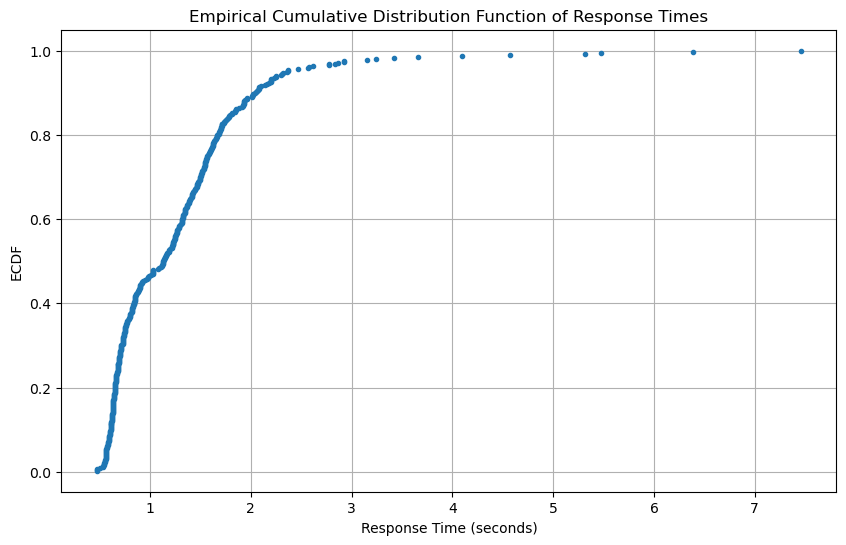

ECDF plot saved to: LLM_segment_111/response_time_ecdf.png


In [ ]:
import pandas as pd
from datetime import timedelta
import time
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional
import re
import os


# Function 1: Generate natural language descriptions with token and time tracking
def generate_natural_language_description(df):
    """
    Convert sensor state data into a natural language description using LLM.
    Tracks token usage and response time. Adapted for event-based windows without activity column.
    """
    # 确保时间列是 datetime 类型
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['end_time'] = pd.to_datetime(df['end_time'])
    
    # 获取窗口的起始和结束时间
    window_start = df['start_time'].min()
    window_end = df['end_time'].max()
    window_time_str = window_start.strftime('%I:%M %p').lstrip('0')
    
    # 按开始时间排序
    df = df.sort_values('start_time')
    
    # 生成事件列表
    events = []
    for _, row in df.iterrows():
        # 从 state 中提取状态名称 (e.g., Kitchen-FridgeDoorOpen)
        state_name = row['state'].split('(')[1].split(',')[0] if '(' in row['state'] else row['state']
        duration = (row['end_time'] - row['start_time']).total_seconds()
        event = {
            'state': state_name,
            'place': row['place'].lower(),
            # 'location': row['location'].lower(),
            # 'type': row['type'].lower(),
            # 'device': row['device'].lower(),
            'duration': int(duration) if duration > 0 else 1,
            'start_time': row['start_time'].strftime('%I:%M %p').lstrip('0'),
            'end_time': row['end_time'].strftime('%I:%M %p').lstrip('0')
        }
        events.append(event)
    
    # 构造提示词（去掉 activity 相关内容）
    prompt = f"""
    The data comes from an event-based time window starting around {window_time_str}.
    Here is the list of recorded events:
    {events}
    
    Please generate a natural language description based on these events, following these guidelines:
    - Start with "Around {window_time_str}, ".
    - Indicate the subject's location and describe their activities based on the state, place, and device information.
    - Use connecting words (like "then", "while", or "after") to make the description flow smoothly.
    - Incorporate approximate times (start_time) where relevant to provide a sense of sequence.
    """

    print(prompt)
    
    try:
        start_time = time.time()
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "You are a helpful intelligent assistant tasked with converting sensor data into smooth, natural English descriptions"},
                {"role": "user", "content": prompt}
            ],
            max_tokens=500,
            temperature=0.0
        )
        end_time = time.time()
        
        response_time = end_time - start_time
        tokens_used = response.usage.total_tokens if hasattr(response, 'usage') else 0
        
        return {
            'description': response.choices[0].message.content.strip(),
            'response_time': response_time,
            'tokens_used': tokens_used
        }
    except Exception as e:
        return {
            'description': f"Error generating description: {str(e)}",
            'response_time': 0,
            'tokens_used': 0
        }

# Function 2: Classify a single description with token and time tracking
def classify_single_activity(description):
    system_prompt = """
    Act as a human activity recognition system that infers the activities performed by a subject in their home.
    The home has the following locations: 'bathroom', 'bedroom', 'kitchen', and 'living room', and 'entrance (main door)'
    The system captures the subject's interactions with: Shower, Basin, Cooktop, Maindoor, Fridge, Cabinet, Cupboard, Toilet, Microwave, Seat, Bed, Toaster.
    I will provide you with a description of what happened during a specific time window, and your goal is to provide the most likely activity.
    The possible activities are: sleeping,showering,preparing breakfast,personal care,relaxing on couch,leaving home,preparing lunch,snacking
    Your answer should be one or more of these activities using the following format: ACTIVITY=(activity name) or ACTIVITY=(activity name,activity name)
    """
    
    try:
        start_time = time.time()
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": description}
            ],
            stream=False,
            temperature=0.0
        )
        end_time = time.time()
        
        response_time = end_time - start_time
        tokens_used = response.usage.total_tokens if hasattr(response, 'usage') else 0
        
        activity_str = response.choices[0].message.content.strip()
        activity_label = extract_activity_label(activity_str)
        
        return {
            'activity': activity_label if activity_label else "Unknown",
            'response_time': response_time,
            'tokens_used': tokens_used
        }
    except Exception as e:
        return {
            'activity': f"Error: {str(e)}",
            'response_time': 0,
            'tokens_used': 0
        }

# Helper function to extract activity label
def extract_activity_label(response: str) -> Optional[str]:
    """Extract the activity label from the model response."""
    match = re.search(r"ACTIVITY=(.*)", response)
    if match:
        return match.group(1).strip()
    return None

# Modified pipeline execution with tracking and ECDF plotting
def run_pipeline(windows, desc_output_path=f'LLM_segment_A/descriptions_{DATASET}.txt', 
                 label_output_path=f'LLM_segment_A/predictions_{DATASET}.txt',
                 metrics_output_path=f'LLM_segment_A/metrics_{DATASET}.txt'):
    """
    Run the pipeline: generate description, classify it, track metrics, and plot ECDF of response times.
    """
    os.makedirs(os.path.dirname(desc_output_path), exist_ok=True)
    
    response_times = []
    total_tokens = 0
    all_tokens = []

    with open(desc_output_path, 'w', encoding='utf-8') as desc_file, \
         open(label_output_path, 'w', encoding='utf-8') as label_file, \
         open(metrics_output_path, 'w', encoding='utf-8') as metrics_file:
        
        for idx, window in enumerate(windows):
            # Step 1: Generate description
            desc_result = generate_natural_language_description(window)
            description = desc_result['description']
            desc_time = desc_result['response_time']
            desc_tokens = desc_result['tokens_used']
            
            # Step 2: Classify the description
            class_result = classify_single_activity(description)
            activity_label = class_result['activity']
            class_time = class_result['response_time']
            class_tokens = class_result['tokens_used']
            
            # Track metrics
            response_times.extend([desc_time, class_time])
            total_tokens += desc_tokens + class_tokens
            all_tokens.extend([desc_tokens, class_tokens])

            # Print results
            print(f"Window {idx + 1}:")
            print(f"Description: {description}")
            print(f"Classified Activity: {activity_label}")
            print(f"Description Time: {desc_time:.2f}s, Tokens: {desc_tokens}")
            print(f"Classification Time: {class_time:.2f}s, Tokens: {class_tokens}\n")
            
            # Save to files
            desc_file.write(f"{description}\n")
            label_file.write(f"{activity_label}\n")
            metrics_file.write(f"Window {idx + 1}:\n")
            metrics_file.write(f"Description Time: {desc_time:.2f}s, Tokens: {desc_tokens}\n")
            metrics_file.write(f"Classification Time: {class_time:.2f}s, Tokens: {class_tokens}\n\n")

        print(f"\nTotal windows processed: {len(windows)}")
        print(f"Total tokens used: {total_tokens}")
        print(f"Descriptions saved to: {desc_output_path}")
        print(f"Activity labels saved to: {label_output_path}")
        print(f"Metrics saved to: {metrics_output_path}") # 添加了metrics的保存路径输出

        # Save all tokens to the metrics file
        # metrics_file.write("\nAll tokens used (description, classification):\n")
        # for tokens in all_tokens:
        #     metrics_file.write(f"{tokens}\n")

    # Generate and plot ECDF
    plot_ecdf(response_times)

def plot_ecdf(response_times):
    """Generate and display ECDF plot of response times."""
    sorted_times = np.sort(response_times)
    y = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
    
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_times, y, marker='.', linestyle='none')
    plt.xlabel('Response Time (seconds)')
    plt.ylabel('ECDF')
    plt.title('Empirical Cumulative Distribution Function of Response Times')
    plt.grid(True)
    
    # Save plot
    plot_path = f'LLM_segment_A/response_time_ecdf.png'
    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
    plt.savefig(plot_path)
    plt.show()
    print(f"ECDF plot saved to: {plot_path}")

# Run the pipeline
test = loaded_dataframes.copy()
run_pipeline(test)

In [9]:
from evaluation.evaluator import evaluate_predictions_split_activities

evaluate_predictions_split_activities(DATA_DIR, DATASET, f"{DATA_DIR}/truth_labels.txt", 
                                      f"{DATA_DIR}/predictions_final_A.txt",
                                      f"{DATA_DIR}/evaluation.txt")

True labels file: LLM_segment_A/truth_labels.txt
Predicted labels file: LLM_segment_A/predictions_final_A.txt
Output file: LLM_segment_A/evaluation.txt
Evaluation results saved to LLM_segment_A/evaluation.txt
Comprehensive confusion matrix saved to LLM_segment_A\confusion_matrix_all_activities.png
Micro-F1 Score (Global): 0.9111
Macro-F1 Score (Class Average): 0.8952
Weighted F1 Score (Weighted Average): 0.9143
Sample-average F1 Score (Sample Average): 0.9205
Mean Jaccard Similarity: 0.9071
